# Conv-6: Convolutional Neural Network with CIFAR10 and PyTorch

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Hyper-parameters-
num_epochs = 50
batch_size = 64
learning_rate = 0.001

### CIFAR-10 Data Pre-preprocessing

__Insight:__

```transforms.ToTensor()``` is similar to TensorFlow's ```X_train /= 255.0``` and ```X_test /= 255.0``` to get the resulting pixel values in the range of 0-1.

In [ ]:
'''
# train dataset-
transforms.Normalize(
    mean = [0.49139968, 0.48215841, 0.44653091],
    std = [0.24703223, 0.24348513, 0.26158784],
    inplace = False
)
'''

In [ ]:
'''
# test dataset-
transforms.Normalize(
    mean = [0.49421428, 0.48513139, 0.45040909],
    std = [0.24665252, 0.24289226, 0.26159238],
    inplace = False
)
'''

In [ ]:
# train dataset transform-
'''
transforms.Normalize(
    mean = [0.49139968, 0.48215841, 0.44653091],
    std = [0.24703223, 0.24348513, 0.26158784],
    inplace = False
)

# transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
'''

# test dataset transform-
'''
transforms.Normalize(
    mean = [0.49421428, 0.48513139, 0.45040909],
    std = [0.24665252, 0.24289226, 0.26159238],
    inplace = False
)
'''
# transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [7]:
path_to_data = "C:\\Users\\arjun\Downloads\\"

#### ```transforms.ToTensor()```

Convert a _PIL Image_ or _numpy.ndarray_ to tensor. This transform does not support torchscript.

Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has ```dtype = np.uint8```.

In the other cases, tensors are returned without scaling.

__Note:__ Because the input image is scaled to [0.0, 1.0], this transformation should not be used when transforming target image masks.

In [8]:
# Dataset has PILImage images of range [0, 1]. We transform them to Tensors
# of normalized range [-1, 1].

# Define transformations for CIFAR-10 training & test sets-
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(size = 32, padding = 4),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ToTensor()
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

In [9]:
# Load CIFAR-10 dataset-
train_dataset = torchvision.datasets.CIFAR10(
        root = path_to_data + 'data', train = True,
        download = True, transform = transform_train
        )

test_dataset = torchvision.datasets.CIFAR10(
        root = path_to_data + 'data', train = False,
        download = True, transform = transform_test
        )

Files already downloaded and verified
Files already downloaded and verified


In [10]:
print(f"training dataset shape: {train_dataset.data.shape} & test dataset shape:"
     f" {test_dataset.data.shape}")

training dataset shape: (50000, 32, 32, 3) & test dataset shape: (10000, 32, 32, 3)


In [11]:
print("train_dataset statistics for all channels:")
print(f"mean for all channels = {train_dataset.data.mean(axis = (0, 1, 2)) / 255}")
print(f"std dev for all channels = {train_dataset.data.std(axis = (0, 1, 2)) / 255}")

train_dataset statistics for all channels:
mean for all channels = [0.49139968 0.48215841 0.44653091]
std dev for all channels = [0.24703223 0.24348513 0.26158784]


In [12]:
print("test_dataset statistics for all channels:")
print(f"mean for all channels = {test_dataset.data.mean(axis = (0, 1, 2)) / 255}")
print(f"std dev for all channels = {test_dataset.data.std(axis = (0, 1, 2)) / 255}")

test_dataset statistics for all channels:
mean for all channels = [0.49421428 0.48513139 0.45040909]
std dev for all channels = [0.24665252 0.24289226 0.26159238]


In [13]:
# Sanity check-
train_dataset.data.min(), train_dataset.data.max()

(0, 255)

In [14]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = False
)

In [15]:
print(f"Sizes of train_dataset: {len(train_dataset)} and test_dataet: {len(test_dataset)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 50000 and test_dataet: 10000
Sizes of train_loader: 782 and test_loader: 157


In [16]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 782 & len(test_loader) = 157


In [17]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(781.25, 156.25)

In [18]:
# next(iter(train_loader))
train_loader.dataset.data.shape

(50000, 32, 32, 3)

In [19]:
# Sanity check- Pixel values are in the range [0,1]-
for images, labels in train_loader:
    if images.min() != 0:
        print(f"images.min() = {images.min():.2f}")
    if images.max() != 1:
        print(f"images.max() = {images.max():.2f}")

In [20]:
# Sanity check- Pixel values are in the range [0,1]-
for images, labels in test_loader:
    if images.min() != 0:
        print(f"images.min() = {images.min():.2f}")
    if images.max() != 1:
        print(f"images.max() = {images.max():.2f}")

In [21]:
images, labels = next(iter(train_loader))

In [22]:
images = images.cpu().detach().numpy()
labels = labels.cpu().detach().numpy()

In [23]:
# De-normalize the batch of images-
images = images / 2 + 0.5

In [24]:
images = np.transpose(images, (0, 2, 3, 1))

In [25]:
images.shape

(64, 32, 32, 3)

In [26]:
images.min(), images.max()

(0.5, 1.0)

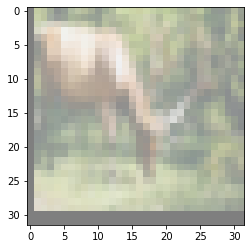

In [27]:
plt.imshow(images[2])

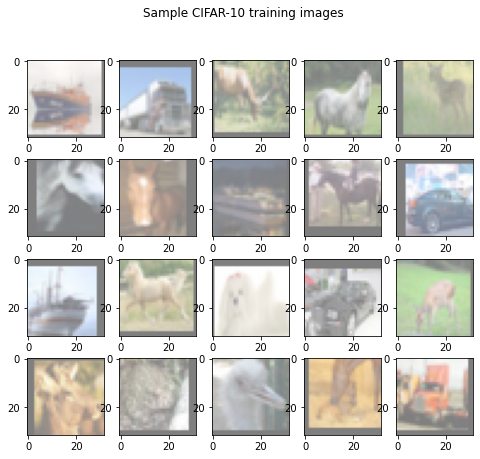

In [28]:
# Visualize 20 images from training set-
plt.figure(figsize = (8, 7))
for i in range(20):
    # 4 rows and 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[i])
    
plt.suptitle("Sample CIFAR-10 training images")
plt.show()

### Define _Conv-6_ CNN architecture

In [29]:
class cnn_block(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(cnn_block, self).__init__()
        
        # Define layers-
        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = output_channels,
            kernel_size = 3, stride = 1,
            padding = 1, bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = output_channels, out_channels = output_channels,
            kernel_size = 3, stride = 1,
            padding = 1, bias = True
        )
        self.pool = nn.MaxPool2d(
            kernel_size = 2, stride = 2
        )
        
        self.initialize_weights()
  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.pool(x)
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        print(f"Conv1 output shape: {x.shape}")
        x = self.conv2(x)
        print(f"Conv2 output shape: {x.shape}")
        x = self.pool(x)
        print(f"Pooling output shape: {x.shape}")
        del x
        return None
    
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
        

In [30]:
class Conv6(nn.Module):
    def __init__(self):
        super(Conv6, self).__init__()
        
        self.block1 = cnn_block(input_channels = 3, output_channels = 64)
        self.block2 = cnn_block(input_channels = 64, output_channels = 128)
        self.block3 = cnn_block(input_channels = 128, output_channels = 256)
        
        self.fc1 = nn.Linear(
            in_features = 256 * 4 * 4, out_features = 256,
            bias = True
        )
        self.fc2 = nn.Linear(
            in_features = 256, out_features = 256,
            bias = True
        )
        self.op_layer = nn.Linear(
            in_features = 256, out_features = 10,
            bias = True
        )
        
        self.initialize_weights()
    

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.op_layer(x)


    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.block1(x)
        print(f"conv block1 output shape: {x.shape}")
        x = self.block2(x)
        print(f"conv block2 output shape: {x.shape}")
        x = self.block3(x)
        print(f"conv block3 output shape: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        print(f"flattened shape: {x.shape}")
        x = self.fc1(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.fc2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.op_layer(x)
        print(f"output shape: {x.shape}")
        del x
        return None
    
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    

In [31]:
# Instantiate an instance of CNN model-
model = Conv6().to(device)

In [32]:
# Sanity check-
images, labels = next(iter(train_loader))

In [33]:
images = images.to(device)

In [34]:
labels_pred = model(images)

In [35]:
labels.shape, labels_pred.shape

(torch.Size([64]), torch.Size([64, 10]))

In [36]:
_, labels_pred = torch.max(labels_pred, 1)
labels_pred.shape

torch.Size([64])

In [37]:
model.shape_computation(images)

Input shape: torch.Size([64, 3, 32, 32])
conv block1 output shape: torch.Size([64, 64, 16, 16])
conv block2 output shape: torch.Size([64, 128, 8, 8])
conv block3 output shape: torch.Size([64, 256, 4, 4])
flattened shape: torch.Size([64, 4096])
dense1 output shape: torch.Size([64, 256])
dense2 output shape: torch.Size([64, 256])
output shape: torch.Size([64, 10])


In [38]:
del images, labels, labels_pred

In [39]:
print(model)

Conv6(
  (block1): cnn_block(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): cnn_block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): cnn_block(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (op_layer): Linear(in_features=256, out_feat

In [40]:
# Count number of trainable parameters per layer-
tot_params = 0
for layer in model.parameters():
    print(f"layer.shape: {layer.shape} has {layer.nelement()} parameters")
    tot_params += layer.nelement()

layer.shape: torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape: torch.Size([64]) has 64 parameters
layer.shape: torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape: torch.Size([64]) has 64 parameters
layer.shape: torch.Size([128, 64, 3, 3]) has 73728 parameters
layer.shape: torch.Size([128]) has 128 parameters
layer.shape: torch.Size([128, 128, 3, 3]) has 147456 parameters
layer.shape: torch.Size([128]) has 128 parameters
layer.shape: torch.Size([256, 128, 3, 3]) has 294912 parameters
layer.shape: torch.Size([256]) has 256 parameters
layer.shape: torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape: torch.Size([256]) has 256 parameters
layer.shape: torch.Size([256, 4096]) has 1048576 parameters
layer.shape: torch.Size([256]) has 256 parameters
layer.shape: torch.Size([256, 256]) has 65536 parameters
layer.shape: torch.Size([256]) has 256 parameters
layer.shape: torch.Size([10, 256]) has 2560 parameters
layer.shape: torch.Size([10]) has 10 parameters


In [41]:
print(f"Conv-6 CNN has {tot_params} parameters.")

Conv-6 CNN has 2262602 parameters.


In [42]:
for layer in model.state_dict().keys():
    print(f"{layer} has shape: {model.state_dict()[layer].shape}")

block1.conv1.weight has shape: torch.Size([64, 3, 3, 3])
block1.conv1.bias has shape: torch.Size([64])
block1.conv2.weight has shape: torch.Size([64, 64, 3, 3])
block1.conv2.bias has shape: torch.Size([64])
block2.conv1.weight has shape: torch.Size([128, 64, 3, 3])
block2.conv1.bias has shape: torch.Size([128])
block2.conv2.weight has shape: torch.Size([128, 128, 3, 3])
block2.conv2.bias has shape: torch.Size([128])
block3.conv1.weight has shape: torch.Size([256, 128, 3, 3])
block3.conv1.bias has shape: torch.Size([256])
block3.conv2.weight has shape: torch.Size([256, 256, 3, 3])
block3.conv2.bias has shape: torch.Size([256])
fc1.weight has shape: torch.Size([256, 4096])
fc1.bias has shape: torch.Size([256])
fc2.weight has shape: torch.Size([256, 256])
fc2.bias has shape: torch.Size([256])
op_layer.weight has shape: torch.Size([10, 256])
op_layer.bias has shape: torch.Size([10])


In [43]:
# Save randomly initialized weights-
torch.save(model.state_dict(), 'Conv6_Random_Wts-CIFAR10.pth')

In [ ]:
"""
# Instantiate a new model and load weights-
random_model = Conv6().to(device)

# Load saved and pre-trained model-
if torch.cuda.is_available():
    random_model.load_state_dict(torch.load('Conv6_Random_Wts-CIFAR10.pth'))
else:
    random_model.load_state_dict(torch.load('Conv6_Random_Wts-CIFAR10.pth', map_location = torch.device('cpu')))
"""

In [44]:
print(f"Adam gradient descent optimizer with learning rate = {learning_rate:.4f} is used")

Adam gradient descent optimizer with learning rate = 0.0010 is used


In [45]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [46]:
num_training_steps = len(train_loader)
print(f"With batch-size = {batch_size} & training set size = {len(train_dataset)}"
      f", number of training steps in 1 epoch = {num_training_steps}")

With batch-size = 64 & training set size = 50000, number of training steps in 1 epoch = 782


In [47]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    

In [48]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [ ]:
'''
# Sanity check-
train_loss, train_acc = train_model_progress(
    model = model, train_loader = train_loader
)
'''

In [ ]:
'''
val_loss, val_acc = test_model_progress(
    model = model, test_loader = test_loader
)
'''

In [ ]:
'''
print(f"train_loss = {train_loss:.4f}, val_loss = {val_loss:.4f}"
      f", train_acc = {train_acc:.2f}% & val_acc = {val_acc:.2f}%"
     )
'''

### Train Conv-6 CNN model with _early stopping_ criterion

In [49]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [50]:
# Initialize parameters for Early Stopping manual implementation-
# best_val_loss = 100
best_val_acc = 0
loc_patience = 0

In [51]:
# Python3 dict to contain training metrics-
train_history = {}

In [52]:
print(f"Train Conv-6 CNN + CIFAR-10 for {num_epochs} epochs")

Train Conv-6 CNN + CIFAR-10 for 50 epochs


In [53]:
for epoch in range(1, num_epochs + 1):
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    
    # One epoch of training-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader
    )
    
    # Get validation metrics after 1 epoch of training-
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = test_loader
    )
    
    # Save training metrics to Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss,
        'train_acc': train_acc, 'val_acc': val_acc
    }
    
    # Code for manual Early Stopping:
    '''
    # Save model with best validation loss-
    if (val_loss < best_val_loss) and \
    (np.abs(val_loss - best_val_loss) >= minimum_delta):
    '''
    # Save model with best validation accuracy-
    if (val_acc > best_val_acc) and (np.abs(val_acc - best_val_acc) >= minimum_delta):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        # best_val_loss = val_loss
        best_val_acc = val_acc
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        # print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        
        # Save trained model with 'best' validation loss-
        # torch.save(model.state_dict(), "Conv6_CIFAR10_best_val_loss.pth")
        torch.save(model.state_dict(), "Conv6_CIFAR10_best_val_acc.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
        
    

Validation: : 100%|███████████████████████████████████| 157/157 [00:01<00:00, 79.76batch/s, val_acc=57.5, val_loss=1.2]


Saving model with highest val_acc = 57.47%



Validation: : 100%|███████████████████████████████████| 157/157 [00:01<00:00, 79.27batch/s, val_acc=69, val_loss=0.888]


Saving model with highest val_acc = 69.02%



Validation: : 100%|███████████████████████████████████| 157/157 [00:01<00:00, 78.64batch/s, val_acc=74, val_loss=0.747]


Saving model with highest val_acc = 74.00%



Validation: : 100%|█████████████████████████████████| 157/157 [00:01<00:00, 79.08batch/s, val_acc=75.5, val_loss=0.693]


Saving model with highest val_acc = 75.53%



Validation: : 100%|█████████████████████████████████| 157/157 [00:01<00:00, 78.76batch/s, val_acc=77.7, val_loss=0.651]


Saving model with highest val_acc = 77.72%



Validation: : 100%|███████████████████████████████████| 157/157 [00:01<00:00, 78.88batch/s, val_acc=80, val_loss=0.588]


Saving model with highest val_acc = 80.03%



Validation: : 100%|█████████████████████████████████| 157/157 [00:01<00:00, 79.40batch/s, val_acc=80.5, val_loss=0.594]


Saving model with highest val_acc = 80.50%



Validation: : 100%|█████████████████████████████████| 157/157 [00:01<00:00, 78.60batch/s, val_acc=82.6, val_loss=0.534]


Saving model with highest val_acc = 82.59%



Validation: : 100%|█████████████████████████████████| 157/157 [00:02<00:00, 76.12batch/s, val_acc=83.3, val_loss=0.503]


Saving model with highest val_acc = 83.29%



Validation: : 100%|█████████████████████████████████| 157/157 [00:01<00:00, 80.08batch/s, val_acc=83.2, val_loss=0.502]


'EarlyStopping' called!



In [ ]:
# Save trained model at last epoch-
# torch.save(model.state_dict(), "Conv6_CIFAR10_last_epoch.pth")

In [54]:
# Save training metrics as pickled object-
with open("Conv6_CIFAR10_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

### Visualization training metrics

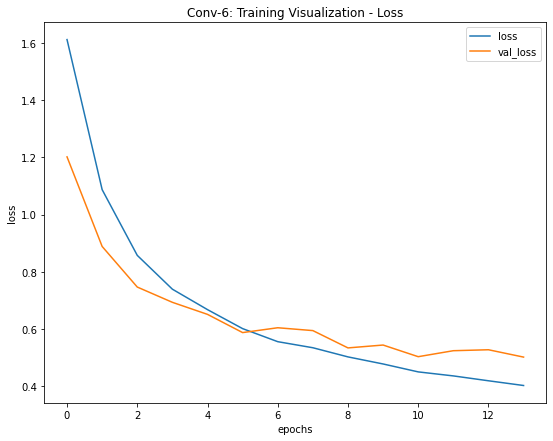

In [55]:
plt.figure(figsize = (9, 7))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conv-6: Training Visualization - Loss")
plt.legend(loc = 'best')
plt.show()

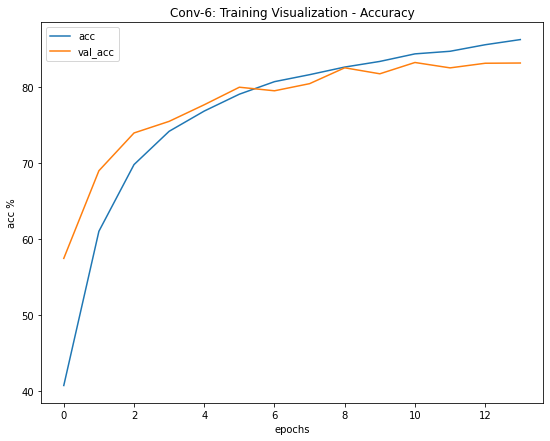

In [56]:
plt.figure(figsize = (9, 7))
plt.plot([train_history[e]['train_acc'] for e in train_history.keys()], label = 'acc')
plt.plot([train_history[e]['val_acc'] for e in train_history.keys()], label = 'val_acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.title("Conv-6: Training Visualization - Accuracy")
plt.legend(loc = 'best')
plt.show()

### Visualize _trained_ layer(s)

In [57]:
# Access each layer-
for layer in model.state_dict().keys():
    print(f"layer: {layer}")

layer: block1.conv1.weight
layer: block1.conv1.bias
layer: block1.conv2.weight
layer: block1.conv2.bias
layer: block2.conv1.weight
layer: block2.conv1.bias
layer: block2.conv2.weight
layer: block2.conv2.bias
layer: block3.conv1.weight
layer: block3.conv1.bias
layer: block3.conv2.weight
layer: block3.conv2.bias
layer: fc1.weight
layer: fc1.bias
layer: fc2.weight
layer: fc2.bias
layer: op_layer.weight
layer: op_layer.bias


In [58]:
# Example - access trained weights of first conv layer-
conv1 = model.state_dict()['block1.conv1.weight']

In [59]:
# Example - access trained weights of sixth conv layer-
conv6 = model.state_dict()['block3.conv2.weight']

In [60]:
conv1 = conv1.cpu().detach().numpy()
conv6 = conv6.cpu().detach().numpy()

In [61]:
conv1.shape, conv6.shape

((64, 3, 3, 3), (256, 256, 3, 3))

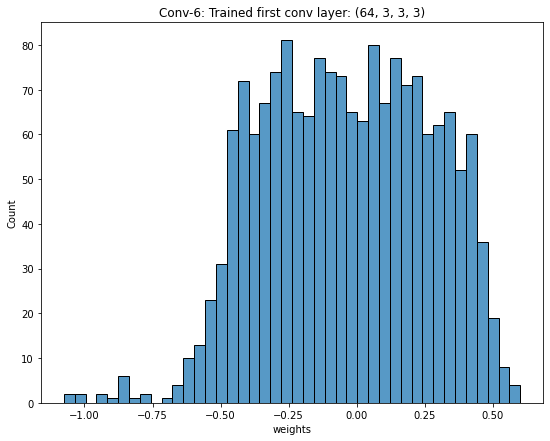

In [62]:
plt.figure(figsize = (9, 7))
sns.histplot(data = conv1.flatten(), bins = int(np.ceil(np.sqrt(conv1.size))))
plt.xlabel("weights")
plt.title("Conv-6: Trained first conv layer: (64, 3, 3, 3)")
plt.show()

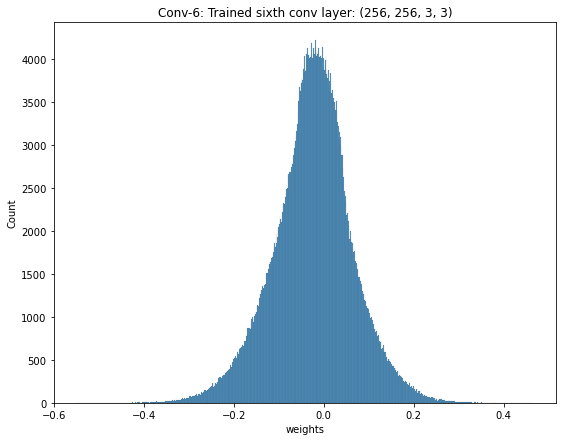

In [63]:
plt.figure(figsize = (9, 7))
sns.histplot(data = conv6.flatten(), bins = int(np.ceil(np.sqrt(conv6.size))))
plt.xlabel("weights")
plt.title("Conv-6: Trained sixth conv layer: (256, 256, 3, 3)")
plt.show()

In [64]:
# Sanity check- Initialize a new model with trained weights-
trained_model = Conv6().to(device)

# Load saved and pre-trained model-
if torch.cuda.is_available():
    trained_model.load_state_dict(torch.load('Conv6_CIFAR10_best_val_acc.pth'))
else:
    trained_model.load_state_dict(torch.load('Conv6_CIFAR10_best_val_acc.pth', map_location = torch.device('cpu')))

In [65]:
# Get model metrics on validation set-
val_loss, val_acc = test_model_progress(
    model = trained_model, test_loader = test_loader
)

Validation: : 100%|█████████████████████████████████| 157/157 [00:02<00:00, 71.84batch/s, val_acc=83.3, val_loss=0.503]


In [66]:
print(f"Trained Conv-6 metrics: val_loss = {val_loss:.4f} &"
      f" val_acc = {val_acc:.3f}%")

Trained Conv-6 metrics: val_loss = 0.5033 & val_acc = 83.290%


In [67]:
del trained_model